In [11]:
import random
from snntorch import functional as SF
import torch.nn as nn
from utils import save_history_plot
import torch
from utils import get_device
import numpy as np
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from single_hidden_layer_1000_neurons_net import SingleHiddenLayer1000NeuronsNet

In [12]:
import torch.nn as nn
import snntorch as snn
import torch

num_hidden = 1000

class SingleHiddenLayer1000NeuronsNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, beta, time_steps):
        super().__init__()

        self.time_steps = time_steps

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.time_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [13]:
time_steps = 100
num_inputs = 700
num_hidden = 1000
num_outputs = 20
dtype = torch.float
batch_size = 32

max_time = 1.4
beta = 0.99
device = get_device()

net = SingleHiddenLayer1000NeuronsNet(num_inputs=num_inputs, num_outputs=num_outputs, beta=beta, time_steps=time_steps).to(device)


frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=time_steps
)

train_data = datasets.SHD("./data", transform=frame_transform, train=True)
test_data = datasets.SHD("./data", transform=frame_transform, train=False)

train_data_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_data_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

In [14]:
selection_index = 0

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]

In [15]:
hidden_spk_rec, _, output_spk_rec, _ = net(data)


x_hidden_selected = hidden_spk_rec[:, selection_index, :]
x_output_selected = output_spk_rec[:, selection_index, :]

x_hidden_selected.shape

torch.Size([100, 1000])

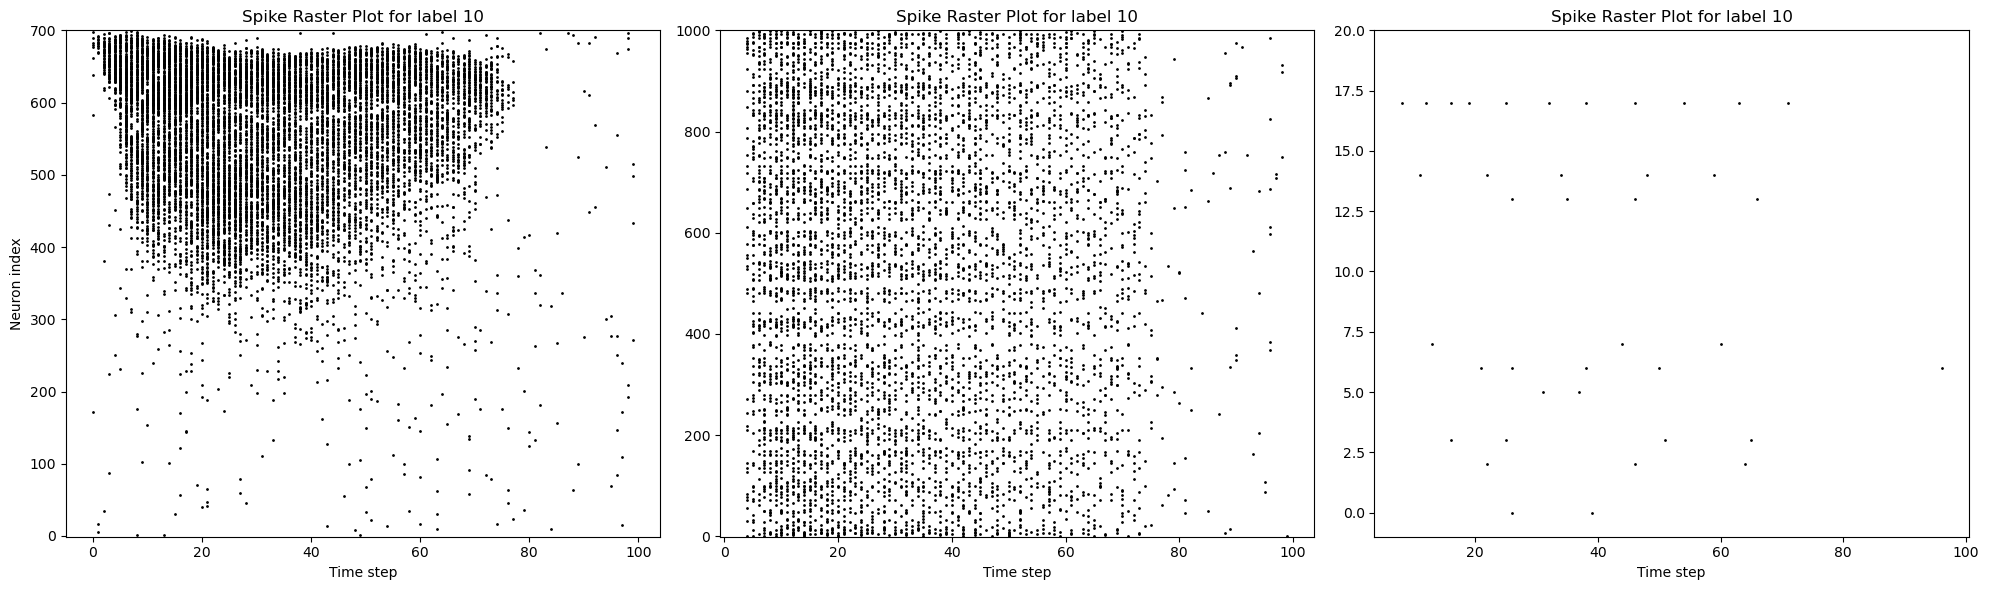

In [16]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices = [x_selected, x_hidden_selected.detach(), x_output_selected.detach()]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for index, ax in enumerate(axes):
    spike_matrix_np = spike_matrices[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)

    ax.scatter(times, neurons, s=1, color='black')
    ax.set_xlabel("Time step")
    ax.set_title(f"Spike Raster Plot for label {y_selected}")

    ax.set_ylim(-1, spike_matrices[index].shape[1])

axes[0].set_ylabel("Neuron index") 
plt.tight_layout()
plt.show()


In [ ]:
from train_simplified_snn import calculate_loss_over_all_timesteps, calculate_gradient, update_weights
import torch.nn as nn

num_epochs = 3
LOSS_FUNCTION = nn.CrossEntropyLoss()

global_loss_hist = []
global_acc_hist = []

optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")

    for i, (data, targets) in enumerate(train_data_loader):
        loss_hist = []
        acc_hist = []

        data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)
        targets = targets.to(device)

        hidden_spk_rec, hidden_mem_rec, spk_rec, mem_rec = net(data)

        loss_val = calculate_loss_over_all_timesteps(time_steps, mem_rec, targets.long(), LOSS_FUNCTION)

        calculate_gradient(optimizer=optimizer, loss_val=loss_val)
        update_weights(optimizer=optimizer)
        
        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        
    print(f"loss {loss_val.item()}")
    print(f"accuracy {np.array(acc_hist).mean()}")
    
    global_loss_hist.append(loss_val.item())
    global_acc_hist.append(np.array(acc_hist).mean())

save_history_plot(global_loss_hist, name='simplified_loss')
save_history_plot(global_acc_hist, name='simplified_accuracy')

Epoch: 0
loss 205.3355255126953
accuracy 0.2857142857142857
Epoch: 1
